# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [159]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

#as noted Kmeans is the technique which going to be used
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [160]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv' , sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv' , sep = ';')

In [161]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print(f'azdias rows:{azdias.shape[0]}\nazdias columns: {azdias.shape[1]}')




azdias rows:891221
azdias columns: 85


In [162]:
#First top 5 rows of azdias
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [163]:
#Last 5 buttom rows of azdias

azdias.tail()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
891216,-1,3,2,5.0,1,4,2,5,4,4,...,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,-1,2,1,4.0,3,3,3,2,2,3,...,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,-1,2,2,4.0,2,4,2,5,4,3,...,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,-1,1,1,3.0,1,5,3,5,5,5,...,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0
891220,-1,4,1,1.0,4,2,5,2,1,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,4.0,5.0


In [164]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

#### $\color{red}{\text{There are 1000 to 14000 missing values in some features !}}$


----------------------------------------

In [165]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


-----------------------

####  $\color{red}{\text{Features information dataset: feat_info}}$


In [166]:
# making pandas view all rows upon display

with pd.option_context('display.max_rows' , None):
    print(feat_info)

                attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numeric                [0]
12        GF

In [167]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   attribute           85 non-null     object
 1   information_level   85 non-null     object
 2   type                85 non-null     object
 3   missing_or_unknown  85 non-null     object
dtypes: object(4)
memory usage: 2.8+ KB


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [168]:
feat_info.iloc[59]

attribute             CAMEO_INTL_2015
information_level       microcell_rr4
type                            mixed
missing_or_unknown            [-1,XX]
Name: 59, dtype: object

In [169]:
print(feat_info.missing_or_unknown.iloc[59][1:-1])

-1,XX


In [170]:
# Identify missing or unknown data values and convert them to NaNs.



# turning column into list 
# mou: missing or unknown
mou = feat_info['missing_or_unknown'].tolist()





"""
# recursiveParse(counter): this is a recursive method. It's main goal is to parse the values of original column[4] of feat_info


var:
    -counter: tracker of current row
    -new_mou: new missing or unknown list values after parsing

    

"""

def recursiveParse(counter , new_mou):
    
    # Stopping condition
    if counter > 84:
        return 
        
    
    # Inner list to help us append a list into the bigger list "new_mou" 
    #---> [ [row#0 vals] , [row#1 vals] , .. , row#n vals]
    inner_new_mou = []
    """
    # current: current value taken from "mou"  
    
    # 1: take out "[]" since it's saved as whole string
    # 2 :then split that string into list   --> split returns a string into a list splitted by a split factor
    
    """
    #1
    current = mou[counter][1:-1]

    #2
    current = current.split(',')
  
   
    
    # loops through current row list to abstract values and parse it as proper
    for value in current:
        if value != '' and value != 'X' and value != 'XX':
            inner_new_mou.append(int(value))
            
            
        else:
            inner_new_mou.append(value)
            
    
    # append operation to bigger list
    new_mou.append(inner_new_mou)
        
    
    
    counter+=1
    recursiveParse(counter , new_mou)        
    

        



In [171]:
# counter
c = 0

# list
new_mou = []

# call recursive function
recursiveParse(c , new_mou)



#let's append new values to original dataframe 

feat_info['missing_or_unknown'] = new_mou



In [172]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### $\color{red}{\text{Lets check on new values of feat_info dataframe}}$

In [173]:
# replace unknown values with nan

#it's some time to execute ;)
        
index = 0
while index < len(azdias.columns):
    
    temp = azdias.columns[index]
    if feat_info.set_index('attribute').T[temp].missing_or_unknown != []:
        azdias[temp].replace(feat_info.set_index('attribute').T[temp].missing_or_unknown , np.nan , inplace = True)
        index +=1

In [174]:
azdias.head()



,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


------------

#### $\color{red}{\text{Validating changes}}$


In [175]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [176]:

print((azdias['AGER_TYP'] == -1).any() , (azdias['CAMEO_INTL_2015'] == 'XX').any())

False False


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [177]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

labels = azdias.columns

# tnv: total null values for each column
tnv = azdias.isnull().sum()

tnv = tnv[tnv > 0] * 100 / (azdias.shape[0])

with pd.option_context('display.max_rows' , None):
    print(tnv)

AGER_TYP                 76.955435
ALTERSKATEGORIE_GROB      0.323264
CJT_GESAMTTYP             0.544646
GEBURTSJAHR              44.020282
GFK_URLAUBERTYP           0.544646
HEALTH_TYP               12.476816
LP_LEBENSPHASE_FEIN      10.954859
LP_LEBENSPHASE_GROB      10.611509
LP_FAMILIE_FEIN           8.728699
LP_FAMILIE_GROB           8.728699
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
RETOURTYP_BK_S            0.544646
SHOPPER_TYP              12.476816
SOHO_KZ                   8.247000
TITEL_KZ                 99.757636
VERS_TYP                 12.476816
ALTER_HH                 34.813699
ANZ_PERSONEN              8.247000
ANZ_TITEL                 8.247000
HH_EINKOMMEN_SCORE        2.058749
KK_KUNDENTYP             65.596749
W_KEIT_KIND_HH           16.605084
WOHNDAUER_2008            8.247000
ANZ_HAUSHALTE_AKTIV      11.176913
ANZ_HH_TITEL             10.884842
GEBAEUDETYP         

In [178]:
#tnv_df = tnv.to_frame()

tnv_df = pd.DataFrame(data = tnv , columns = ['values'])


with pd.option_context('display.max_rows' , None):
    print(tnv_df)
    
tnv_df.head()

                          values
AGER_TYP               76.955435
ALTERSKATEGORIE_GROB    0.323264
CJT_GESAMTTYP           0.544646
GEBURTSJAHR            44.020282
GFK_URLAUBERTYP         0.544646
HEALTH_TYP             12.476816
LP_LEBENSPHASE_FEIN    10.954859
LP_LEBENSPHASE_GROB    10.611509
LP_FAMILIE_FEIN         8.728699
LP_FAMILIE_GROB         8.728699
LP_STATUS_FEIN          0.544646
LP_STATUS_GROB          0.544646
NATIONALITAET_KZ       12.153551
PRAEGENDE_JUGENDJAHRE  12.136608
RETOURTYP_BK_S          0.544646
SHOPPER_TYP            12.476816
SOHO_KZ                 8.247000
TITEL_KZ               99.757636
VERS_TYP               12.476816
ALTER_HH               34.813699
ANZ_PERSONEN            8.247000
ANZ_TITEL               8.247000
HH_EINKOMMEN_SCORE      2.058749
KK_KUNDENTYP           65.596749
W_KEIT_KIND_HH         16.605084
WOHNDAUER_2008          8.247000
ANZ_HAUSHALTE_AKTIV    11.176913
ANZ_HH_TITEL           10.884842
GEBAEUDETYP            10.451729
KONSUMNAEH

,values
AGER_TYP,76.955435
ALTERSKATEGORIE_GROB,0.323264
CJT_GESAMTTYP,0.544646
GEBURTSJAHR,44.020282
GFK_URLAUBERTYP,0.544646


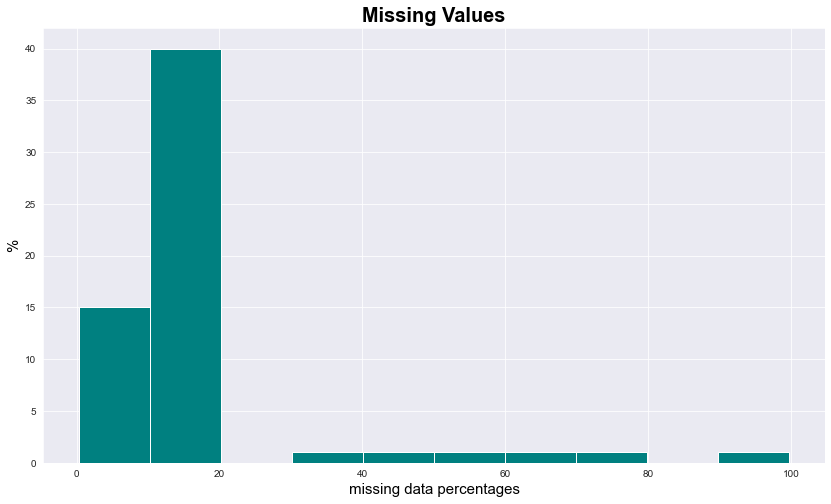

In [179]:
tnv.sort_values(inplace=True)


figure = plt.figure(figsize = (14,8) )
figure = plt.hist(tnv, color = 'teal')

plt.xlabel('missing data percentages', size = 15 , color = 'black' )
plt.ylabel('%', size = 15 , color = 'black' )

plt.title('Missing Values', size = 20 , color = 'black' , weight = 'bold')

plt.grid(True)

plt.show();

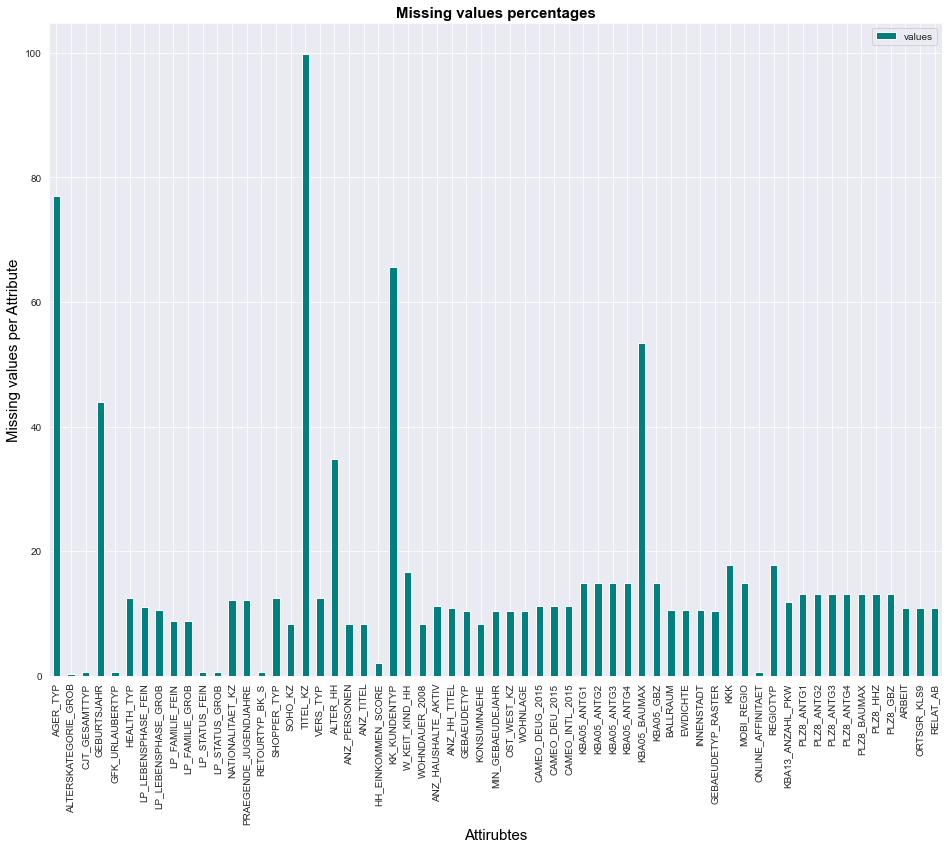

In [180]:
tnv_df.plot.bar(figsize=(16,12) , color = 'teal' )
plt.xlabel('Attirubtes', size = 15 , color = 'black')
plt.ylabel('Missing values per Attribute', size = 15 , color = 'black')
plt.title('Missing values percentages', size = 15 , color = 'black' , weight = 'bold')
plt.show();

In [181]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# Values are already multiplied by 100
drop_rate = (0.25*100)

outliers = tnv[tnv > drop_rate]

outliers


ALTER_HH        34.813699
GEBURTSJAHR     44.020282
KBA05_BAUMAX    53.468668
KK_KUNDENTYP    65.596749
AGER_TYP        76.955435
TITEL_KZ        99.757636
dtype: float64

#### $\color{red}{\text{barplot excluding outliers}}$


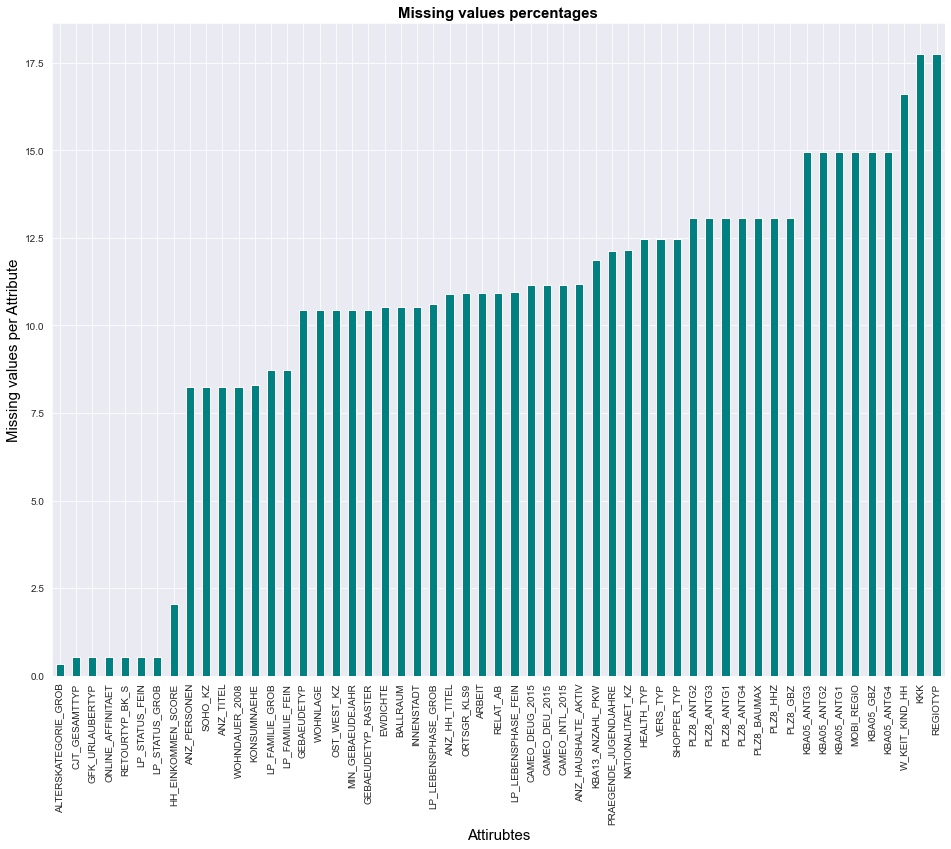

In [182]:
tnv[tnv < drop_rate].plot.bar(figsize=(16,12) , color = 'teal' )
plt.xlabel('Attirubtes', size = 15 , color = 'black')
plt.ylabel('Missing values per Attribute', size = 15 , color = 'black')
plt.title('Missing values percentages', size = 15 , color = 'black' , weight = 'bold')
plt.show();

-------------------------------------

#### $\color{red}{\text{calculating total null overall and in each feature}}$


In [183]:
# calculating total null values 

null_counter = azdias.isnull().sum()
print(f'Total null values in azdias dataframe is :{null_counter[null_counter > 0].sum()} \n============================\n')


with pd.option_context('display.max_rows' , None):
    print(null_counter[null_counter > 0].sort_values())
    



Total null values in azdias dataframe is :8373929 

ALTERSKATEGORIE_GROB       2881
CJT_GESAMTTYP              4854
GFK_URLAUBERTYP            4854
ONLINE_AFFINITAET          4854
RETOURTYP_BK_S             4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
HH_EINKOMMEN_SCORE        18348
ANZ_PERSONEN              73499
SOHO_KZ                   73499
ANZ_TITEL                 73499
WOHNDAUER_2008            73499
KONSUMNAEHE               73969
LP_FAMILIE_GROB           77792
LP_FAMILIE_FEIN           77792
GEBAEUDETYP               93148
WOHNLAGE                  93148
OST_WEST_KZ               93148
MIN_GEBAEUDEJAHR          93148
GEBAEUDETYP_RASTER        93155
EWDICHTE                  93740
BALLRAUM                  93740
INNENSTADT                93740
LP_LEBENSPHASE_GROB       94572
ANZ_HH_TITEL              97008
ORTSGR_KLS9               97274
ARBEIT                    97375
RELAT_AB                  97375
LP_LEBENSPHASE_FEIN       97632
CAMEO_DEUG_2015     

In [184]:
# dropping outliers out of main dataframe 'azdias'

azdias.drop(outliers.index , axis = 1 , inplace = True)

In [185]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [186]:
azdias.shape

(891221, 79)

In [187]:
print(f'{len(outliers)} Attributes dropped of 85 Attributes \nnew Attributes(features) number is: {len(azdias.columns)}')

6 Attributes dropped of 85 Attributes 
new Attributes(features) number is: 79


#### Discussion 1.1.2: Assess Missing Data in Each Column

- There are 8373929 missing values in `Azdias` in total.


- 7% of total features have more than 25% of missing values of overall --> outliers.


- As figure shows, I determined that drop rate = 25% 


- Six features determined to be dropped out of `Azdias` due to high perecentage of missing values, Hence, inaccurate training results rate mitigate


- Six features: 
        
        -AGER_TYP: Best-ager typology
        
        -ALTER_HH: Birthdate of head of household
        
        -GEBURTSJAHR: Year of birth
        
        -KK_KUNDENTYP: Consumer pattern over past 12 months
        
        -TITEL_KZ: Academic title flag
        
        -KBA05_BAUMAX: Most common building type within the microcell

    
- Six features out of 85 have been dropped, Thus, 79 remained.













-------------------------------------

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [188]:
# How much data is missing in each row of the dataset?
# rnr: rows null rate
rnr = (azdias.isna().sum(axis = 1)/len(azdias.columns))

# r : rows
r = azdias.isnull().sum(axis = 1)


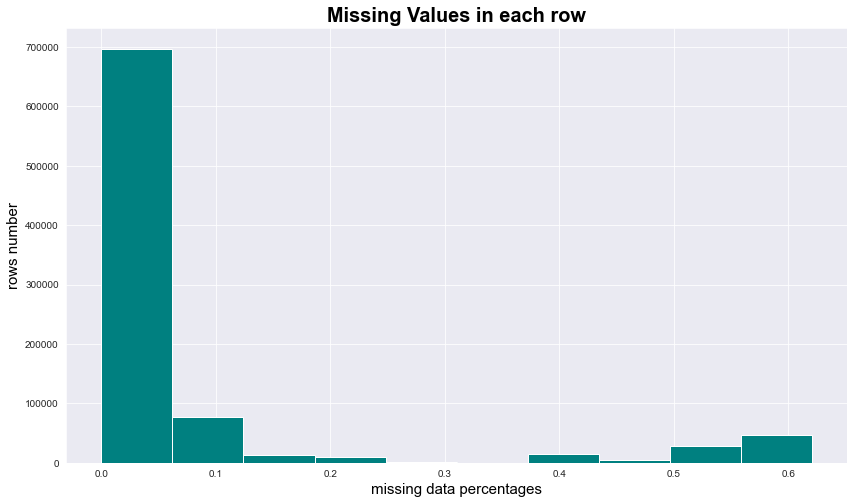

In [189]:


figure = plt.figure(figsize = (14,8) )
figure = plt.hist(rnr, color = 'teal')

plt.xlabel('missing data percentages', size = 15 , color = 'black' )
plt.ylabel('rows number', size = 15 , color = 'black' )

plt.title('Missing Values in each row', size = 20 , color = 'black' , weight = 'bold')

plt.grid(True)

plt.show();

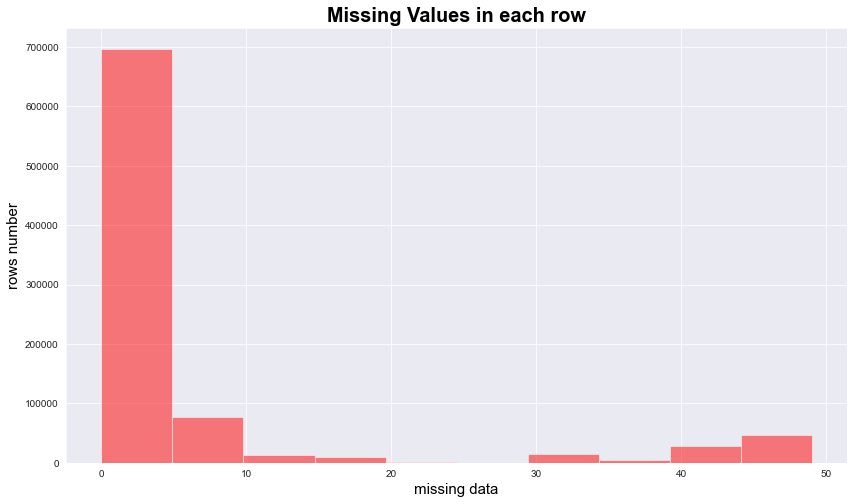

In [190]:


figure = plt.figure(figsize = (14,8) )
figure = plt.hist(r, color = 'red' , alpha = 0.5)

plt.xlabel('missing data', size = 15 , color = 'black' )
plt.ylabel('rows number', size = 15 , color = 'black' )

plt.title('Missing Values in each row', size = 20 , color = 'black' , weight = 'bold')

plt.grid(True)

plt.show();

--------------------------

#### $\color{red}{\text{No missing values columns}}$


In [191]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.


rate = 20


#dividing dataset into two subsets acording to pre_determined threshold (rate) 

low_div = azdias[azdias.isnull().sum(axis = 1) < 20].reset_index(drop  = True)

high_div = azdias[azdias.isnull().sum(axis = 1) >= 20].reset_index(drop = True)


print(low_div.shape , high_div.shape)

(797077, 79) (94144, 79)


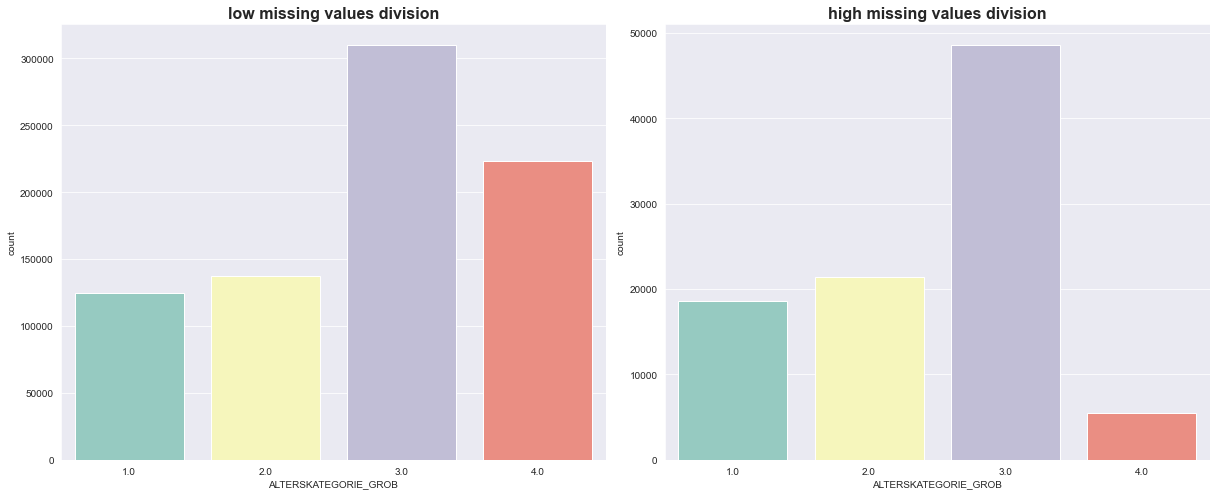

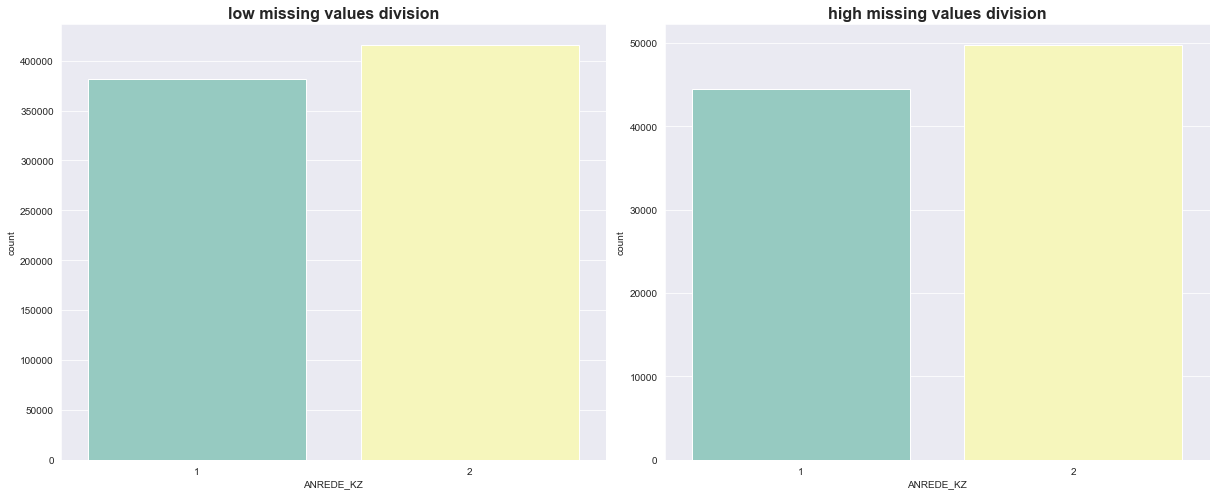

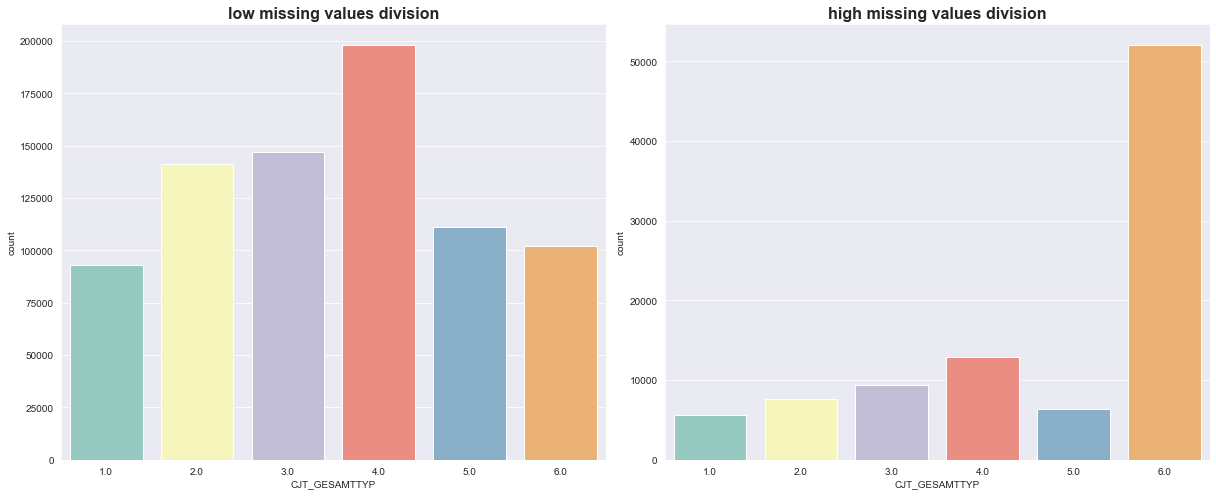

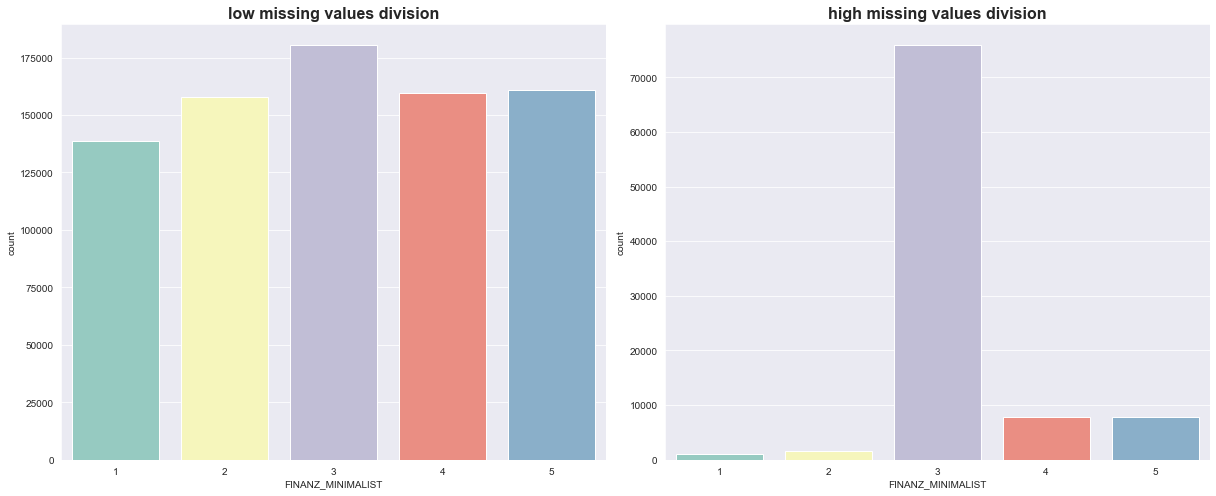

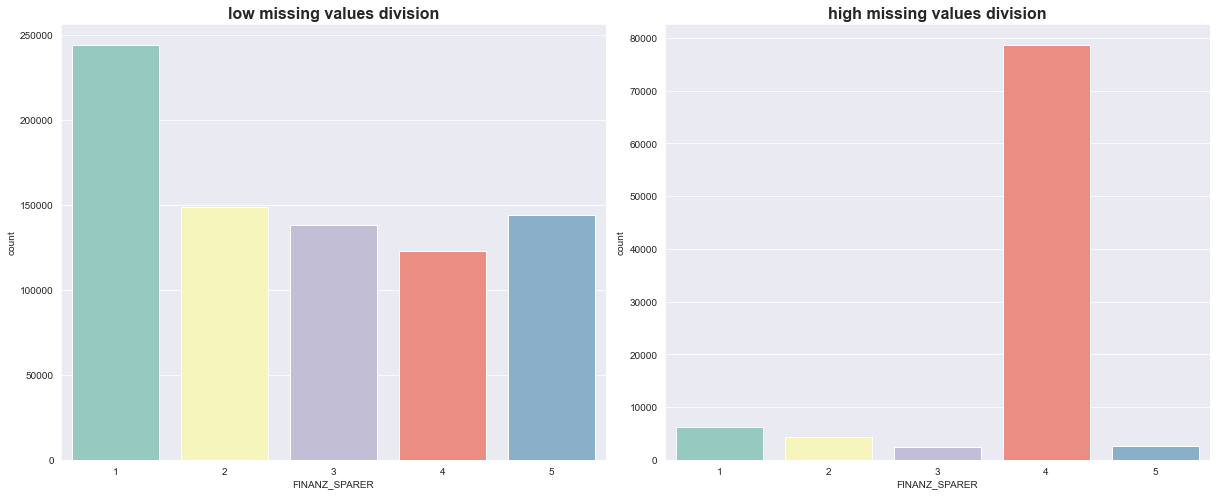

In [192]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

sns.set_style('darkgrid')
sns.set_palette('Set3')

for column in azdias.columns[:5]:
    
        
    fig , ax = plt.subplots(1 , 2 , figsize=(17,7))

    sns.countplot(x = column , data = low_div , ax = ax[0] )
    
    sns.countplot(x = column , data = high_div , ax = ax[1] )

    
    ax[0].set_title('low missing values division' , size = 16 , weight = 'bold')
    ax[1].set_title('high missing values division' , size = 16 , weight = 'bold')
    
    
    fig.tight_layout()


#### Discussion 1.1.3: Assess Missing Data in Each Row

- `ALTERSKATEGORIE_GROB`: Estimated age based on given name analysis
                        
       - 3.0 (46-60 years old) : is high in both low division and high division subset
       - 4.0 (60 > ): unlike 3.0, it's much lower in high division than low division

- `ANREDE_KZ: Gender`
     
       - Both divisions (Subsets): has similiar distribution
       
       
       
- `CJT_GESAMTTYP`: Customer-Journey-Typology: preferred information and buying channels for consumer

       -Unlike `ANREDE_KZ`, variance between is considered high.
     

- `FINANZ`:
       
       - All `FINANZ` columns have huge variance between their divisions, which puts them under special consideration.
       

-------------------------

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [193]:
# How many features are there of each data type?

feat_info.type.value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

#### $\color{red}{\text{Overview}}$

In [194]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?


#overview

with pd.option_context('display.max_rows' , None):
    print(feat_info.query('type == "categorical"')['attribute'])

0             AGER_TYP
2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
40            TITEL_KZ
41            VERS_TYP
42            ZABEOTYP
47        KK_KUNDENTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object


In [195]:

# cf : categorical features
cf = []

for row in feat_info.iterrows():
    if row[1][2] == 'categorical':
        print(row[1][3] , row[1][2] , row[1][0] , sep = " /\|||/\ ")
        cf.append(row[1][0])
        

[-1, 0] /\|||/\ categorical /\|||/\ AGER_TYP
[-1, 0] /\|||/\ categorical /\|||/\ ANREDE_KZ
[0] /\|||/\ categorical /\|||/\ CJT_GESAMTTYP
[-1] /\|||/\ categorical /\|||/\ FINANZTYP
[''] /\|||/\ categorical /\|||/\ GFK_URLAUBERTYP
[''] /\|||/\ categorical /\|||/\ GREEN_AVANTGARDE
[0] /\|||/\ categorical /\|||/\ LP_FAMILIE_FEIN
[0] /\|||/\ categorical /\|||/\ LP_FAMILIE_GROB
[0] /\|||/\ categorical /\|||/\ LP_STATUS_FEIN
[0] /\|||/\ categorical /\|||/\ LP_STATUS_GROB
[-1, 0] /\|||/\ categorical /\|||/\ NATIONALITAET_KZ
[-1] /\|||/\ categorical /\|||/\ SHOPPER_TYP
[-1] /\|||/\ categorical /\|||/\ SOHO_KZ
[-1, 0] /\|||/\ categorical /\|||/\ TITEL_KZ
[-1] /\|||/\ categorical /\|||/\ VERS_TYP
[-1, 9] /\|||/\ categorical /\|||/\ ZABEOTYP
[-1] /\|||/\ categorical /\|||/\ KK_KUNDENTYP
[-1, 0] /\|||/\ categorical /\|||/\ GEBAEUDETYP
[-1] /\|||/\ categorical /\|||/\ OST_WEST_KZ
[-1, 'X'] /\|||/\ categorical /\|||/\ CAMEO_DEUG_2015
['XX'] /\|||/\ categorical /\|||/\ CAMEO_DEU_2015


In [196]:
print(f"Number of categorical features before filtering: {len(cf)}\n")
print(cf)

Number of categorical features before filtering: 21

['AGER_TYP', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [197]:



# fcf : filtered categorical features
fcf = []

# bv : binary variables
bv = []

# nbv : non binary variables

nbv = []


for _ in cf:
    
    # check if column name is in azdias or not
    if _ in azdias.columns:
        fcf.append(_)
        if azdias[_].nunique() == 2:
                bv.append(_)
                print(_ , azdias[_].unique())
                
        else:
            nbv.append(_)
            

ANREDE_KZ [1 2]
GREEN_AVANTGARDE [0 1]
SOHO_KZ [nan  1.  0.]
VERS_TYP [nan  2.  1.]
OST_WEST_KZ [nan 'W' 'O']


------------------------
#### $\color{red}{\text{clearly "OST_WEST_KZ" is the binary feature that takes non-numeric values }}$

------------------------

In [198]:
print(f"Number of categorical features after filtering: {len(fcf)}\n")
print(fcf)

Number of categorical features after filtering: 18

['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


#### $\color{red}{\text{1- Creating dummies for OST_WEST_KZ feature}}$

In [199]:
# Re-encode categorical variable(s) to be kept in the analysis.

# cdf : categorical dataframe 
cdf = azdias[fcf].copy()

cdf.head()

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
0,1,2.0,4,10.0,0,2.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN
1,2,5.0,1,10.0,0,5.0,3.0,2.0,1.0,1.0,3.0,1.0,2.0,5,8.0,W,8,8A
2,2,3.0,1,10.0,1,1.0,1.0,3.0,2.0,1.0,2.0,0.0,1.0,5,1.0,W,4,4C
3,2,2.0,6,1.0,0,NaN,NaN,9.0,4.0,1.0,1.0,0.0,1.0,3,1.0,W,2,2A
4,1,5.0,5,5.0,0,10.0,5.0,3.0,2.0,1.0,2.0,0.0,2.0,4,1.0,W,6,6B


In [200]:
cdf.shape

(891221, 18)

In [201]:
cdf.OST_WEST_KZ.replace(['W' , 'O'] , [1 , 0] , inplace = True)
azdias.OST_WEST_KZ.replace(['W' , 'O'] , [1 , 0] , inplace = True)

In [202]:
azdias.OST_WEST_KZ

0         NaN
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
891216    1.0
891217    1.0
891218    1.0
891219    1.0
891220    1.0
Name: OST_WEST_KZ, Length: 891221, dtype: float64

#### $\color{red}{\text{2- Multi-Level categorical features --> drop}}$

In [203]:
# nbv : non-binary variables
print(nbv)

['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [204]:
cdf.drop(nbv , inplace = True , axis = 1)

In [205]:
cdf.head()

,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ
0,1,0,NaN,NaN,NaN
1,2,0,1.0,2.0,1.0
2,2,1,0.0,1.0,1.0
3,2,0,0.0,1.0,1.0
4,1,0,0.0,2.0,1.0


#### Discussion 1.2.1: Re-Encode Categorical Features


- OST_WEST_KZ : Building location via former East / West Germany (GDR / FRG)
          
          - Non numerical values have been changed to Binary-numeric values.
          
                  O : 0
                  
                  W : 1
                  
                  
                  
                  

- For Binary categorical values nothing was changed.


- For Non-Binary categorical values >>> dropped




----------------------------------
---------------------------------

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [206]:
# creating mixed features dataframe like i did for categorical


#extract mixed-type features out of "feat_info"

# mf : mixed features
mf = []



for row in feat_info.iterrows():
    if row[1][2] == 'mixed':
        print(row[1][3] , row[1][2] , row[1][0] , sep = " /\|||/\ ")
        mf.append(row[1][0])
        




[0] /\|||/\ mixed /\|||/\ LP_LEBENSPHASE_FEIN
[0] /\|||/\ mixed /\|||/\ LP_LEBENSPHASE_GROB
[-1, 0] /\|||/\ mixed /\|||/\ PRAEGENDE_JUGENDJAHRE
[-1] /\|||/\ mixed /\|||/\ WOHNLAGE
[-1, 'XX'] /\|||/\ mixed /\|||/\ CAMEO_INTL_2015
[-1, 0] /\|||/\ mixed /\|||/\ KBA05_BAUMAX
[-1, 0] /\|||/\ mixed /\|||/\ PLZ8_BAUMAX


In [207]:

# filtered mixed features 

fmf = []

for col in azdias.columns:
    if col in mf:
        fmf.append(col)
        

        
# mdf: mixed dataframe

mdf = azdias[fmf].copy()



mdf.head()



,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,WOHNLAGE,CAMEO_INTL_2015,PLZ8_BAUMAX
0,15.0,4.0,NaN,NaN,NaN,NaN
1,21.0,6.0,14.0,4.0,51,1.0
2,3.0,1.0,15.0,2.0,24,1.0
3,NaN,NaN,8.0,7.0,12,1.0
4,32.0,10.0,8.0,3.0,43,2.0


In [208]:
mdf.shape

(891221, 6)

$\color{red}{\text{as Data Dictionary says:}}$

PRAEGENDE_JUGENDJAHRE: Dominating `movement` of person's youth (avantgarde vs. mainstream; east vs. west)
    
    -  -1: unknown

    -  0: unknown

    -  1: 40s - war years (Mainstream, E+W)

    -  2: 40s - reconstruction years (Avantgarde, E+W)

    -  3: 50s - economic miracle (Mainstream, E+W)

    -  4: 50s - milk bar / Individualisation (Avantgarde, E+W)

    -  5: 60s - economic miracle (Mainstream, E+W)

    -  6: 60s - generation 68 / student protestors (Avantgarde, W)

    -  7: 60s - opponents to the building of the Wall (Avantgarde, E)

    -  8: 70s - family orientation (Mainstream, E+W)

    -  9: 70s - peace movement (Avantgarde, E+W)

    - 10: 80s - Generation Golf (Mainstream, W)

    - 11: 80s - ecological awareness (Avantgarde, W)

    - 12: 80s - FDJ / communist party youth organisation (Mainstream, E)

    - 13: 80s - Swords into ploughshares (Avantgarde, E)

    - 14: 90s - digital media kids (Mainstream, E+W)

    - 15: 90s - ecological awareness (Avantgarde, E+

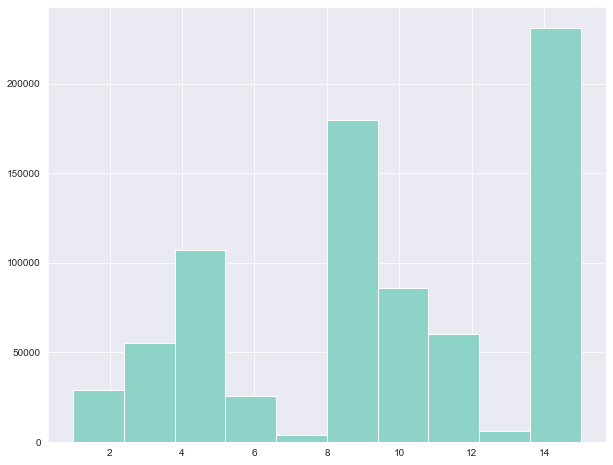

In [209]:
mdf.PRAEGENDE_JUGENDJAHRE.hist(figsize = (10 , 8) );

In [210]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

mdf.PRAEGENDE_JUGENDJAHRE.unique()

array([nan, 14., 15.,  8.,  3., 10., 11.,  5.,  9.,  6.,  4.,  2.,  1.,
       12., 13.,  7.])

In [211]:
mdf['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    188697
8.0     145988
5.0      86416
10.0     85808
3.0      55195
15.0     42547
11.0     35752
9.0      33570
6.0      25652
12.0     24446
1.0      21282
4.0      20451
2.0       7479
13.0      5764
7.0       4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

-----------------
$\color{red}{\text{I am going to create two new variables based on "MOVEMENT" and "DECADE" }}$

In [212]:
# nsv : new structure of variable
nsv = {
       1:1 , 
       2:0 ,
       3:1 ,
       4:0 ,
       5:1 ,
       6:0 , 
       7:0 ,
       8:1 ,
       9:0 ,
       10:1,
       11:0,
       12:1,
       13:0,
       14:1,
       15:0
      }

mdf['MOVEMENT'] = mdf.PRAEGENDE_JUGENDJAHRE.replace(nsv.keys() , nsv.values())

mdf.MOVEMENT.head()

0    NaN
1    1.0
2    0.0
3    1.0
4    1.0
Name: MOVEMENT, dtype: float64

In [213]:
# nsv1: new structure of variable

nsv1 = {
        
    1:1940,
    2:1940,
    3:1950,
    4:1950,
    5:1960,
    6:1960,
    7:1960,
    8:1970,
    10:1980,
    11:1980,
    12:1980,
    13:1980,
    14:1990,
    15:1990

    }

mdf['DECADE'] = mdf.PRAEGENDE_JUGENDJAHRE.replace(nsv1.keys() , nsv1.values())

mdf.DECADE.head()


0       NaN
1    1990.0
2    1990.0
3    1970.0
4    1970.0
Name: DECADE, dtype: float64

In [214]:
# dropping original feature after restructering it into two variables (movement , stage)

mdf.drop(['PRAEGENDE_JUGENDJAHRE'] , inplace = True , axis = 1)
mdf.head()

,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,WOHNLAGE,CAMEO_INTL_2015,PLZ8_BAUMAX,MOVEMENT,DECADE
0,15.0,4.0,NaN,NaN,NaN,NaN,NaN
1,21.0,6.0,4.0,51,1.0,1.0,1990.0
2,3.0,1.0,2.0,24,1.0,0.0,1990.0
3,NaN,NaN,7.0,12,1.0,1.0,1970.0
4,32.0,10.0,3.0,43,2.0,1.0,1970.0


----------------------------
----------------------------
----------------------------
$\color{red}{\text{as Data Dictionary says:}}$

CAMEO_INTL_2015 :German CAMEO: `Wealth` / `Life Stage` Typology, mapped to international code

    - -1: unknown
    
    - 11: Wealthy Households - Pre-Family Couples & Singles
    
    
    - 12: Wealthy Households - Young Couples With Children
    
    - 13: Wealthy Households - Families With School Age Children
    
    - 14: Wealthy Households - Older Families &  Mature Couples
    
    - 15: Wealthy Households - Elders In Retirement
    
    - 21: Prosperous Households - Pre-Family Couples & Singles
    
    - 22: Prosperous Households - Young Couples With Children
    
    - 23: Prosperous Households - Families With School Age Children
    
    - 24: Prosperous Households - Older Families & Mature Couples
    
    - 25: Prosperous Households - Elders In Retirement
    
    - 31: Comfortable Households - Pre-Family Couples & Singles
    
    - 32: Comfortable Households - Young Couples With Children
    
    - 33: Comfortable Households - Families With School Age Children
    
    - 34: Comfortable Households - Older Families & Mature Couples
    
    - 35: Comfortable Households - Elders In Retirement
    
    - 41: Less Affluent Households - Pre-Family Couples & Singles
    
    - 42: Less Affluent Households - Young Couples With Children
    
    - 43: Less Affluent Households - Families With School Age Children
    
    - 44: Less Affluent Households - Older Families & Mature Couples
    
    - 45: Less Affluent Households - Elders In Retirement
    
    - 51: Poorer Households - Pre-Family Couples & Singles
    
    - 52: Poorer Households - Young Couples With Children
    
    - 53: Poorer Households - Families With School Age Children
    
    - 54: Poorer Households - Older Families & Mature Couples
    
    - 55: Poorer Households - Elders In Retirement
    
    - XX: unknown


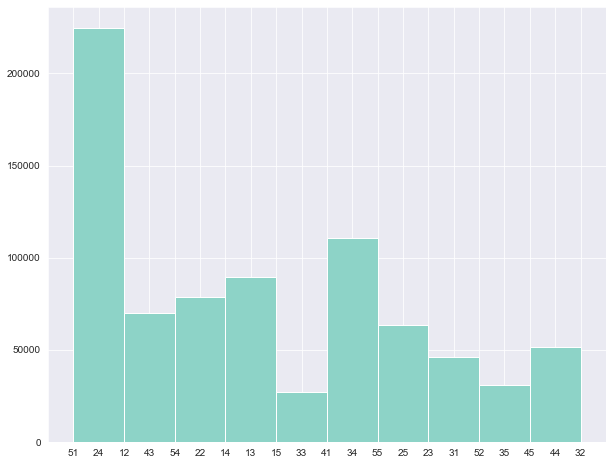

In [215]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

mdf['CAMEO_INTL_2015'].hist(figsize = (10,8));

In [216]:
mdf['CAMEO_INTL_2015'].unique()

array([nan, '51', '24', '12', '43', '54', '22', '14', '13', '15', '33',
       '41', '34', '55', '25', '23', '31', '52', '35', '45', '44', '32'],
      dtype=object)

In [217]:
# converting values from objects (String) to float

mdf['CAMEO_INTL_2015'] = mdf['CAMEO_INTL_2015'].astype(float)

In [218]:
type(mdf['CAMEO_INTL_2015'].iloc[0])

numpy.float64

In [219]:
# nvs3 : new structure of variables (wealth)

nvs3 = {
    
    11:1,
    12:1,
    13:1,
    14:1,
    15:1,
    
    21:2,
    22:2,
    23:2,
    24:2,
    25:2,
    
    31:3,
    32:3,
    33:3,
    34:3,
    35:3,
    
    41:4,
    42:4,
    43:4,
    44:4,
    45:4,
    
    51:5,
    52:5,
    53:5,
    53:5,
    55:5
}


mdf['WEALTH'] = mdf['CAMEO_INTL_2015'].replace(nvs3.keys() , nvs3.values())



# --------------------

# nvs4 : new structure of variables (life stage)

nvs4 = {
    
    11:1,
    12:2,
    13:3,
    14:4,
    15:5,
    
    21:1,
    22:2,
    23:3,
    24:4,
    25:5,
    
    31:1,
    32:2,
    33:3,
    34:4,
    35:5,
    
    41:1,
    42:2,
    43:3,
    44:4,
    45:5,
    
    51:1,
    52:2,
    53:3,
    54:4,
    55:5
    
}

mdf['LIFE_STAGE'] = mdf['CAMEO_INTL_2015'].replace(nvs4.keys() , nvs4.values())


mdf.drop('CAMEO_INTL_2015' , inplace = True , axis = 1)

In [220]:
mdf.head()

,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,WOHNLAGE,PLZ8_BAUMAX,MOVEMENT,DECADE,WEALTH,LIFE_STAGE
0,15.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
1,21.0,6.0,4.0,1.0,1.0,1990.0,5.0,1.0
2,3.0,1.0,2.0,1.0,0.0,1990.0,2.0,4.0
3,NaN,NaN,7.0,1.0,1.0,1970.0,1.0,2.0
4,32.0,10.0,3.0,2.0,1.0,1970.0,4.0,3.0


----------------------------
----------------------------
----------------------------
$\color{red}{\text{I decided to drop other Mixed-Type Features }}$



In [221]:
# dfl : dropped features list
dfl = ['LP_LEBENSPHASE_FEIN' , 'LP_LEBENSPHASE_GROB' , 'WOHNLAGE' , 'PLZ8_BAUMAX']


# drop
mdf.drop(dfl , inplace = True , axis = 1)

# view
mdf.head()

,MOVEMENT,DECADE,WEALTH,LIFE_STAGE
0,NaN,NaN,NaN,NaN
1,1.0,1990.0,5.0,1.0
2,0.0,1990.0,2.0,4.0
3,1.0,1970.0,1.0,2.0
4,1.0,1970.0,4.0,3.0


-----------------------------------------
-----------------------------------------
-----------------------------------------
#### Discussion 1.2.2: Engineer Mixed-Type Features



- `PRAEGENDE_JUGENDJAHRE`: unstructured into two new variables:

        1- MOVEMENT: 
                        - west & mainstream : 1
                        - east & avantgarde : 0
          
        2- DECADE: 
                        
                        - 40s : 1940
                        - 50s : 1950
                              :
                              :
                        - 90s : 1990
                        


- `CAMEO_INTL_2015` : unstructred into two new variables:

       1- WEALTH: 
                   
                       - Wealthy HouseHolds :       11-15
                       
                       - Prosperous HouseHolds :    21-25
                       
                       - Comfortable HouseHolds :   31-35
                       
                       - Less Affluent HouseHolds : 41-45
                       
                       - Poorer HouseHolds :        51-55
                       
       
       2- LIFE_STAGE:
       
                       - Pre-Family Couples & Singles :      11 ,21 ,31 ,41 ,51
                       
                       - Young Couples With Children   :     12, 22, 32, 42, 52
                       
                       - Families With School Age Children : 13, 23, 33, 43, 53
                       
                       - Older Families & Mature Couples  :  14, 24, 34, 44, 54
                       
                       - Elders In Retirement :              15, 25, 35, 45, 55
                       
                       
                       
                       
                       
                       
- `Other`:
         
         
      LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB,  WOHNLAGE, and PLZ8_BAUMAX ---> Dropped
                  

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [222]:
cdf

,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ
0,1,0,NaN,NaN,NaN
1,2,0,1.0,2.0,1.0
2,2,1,0.0,1.0,1.0
3,2,0,0.0,1.0,1.0
4,1,0,0.0,2.0,1.0
...,...,...,...,...,...
891216,2,0,0.0,1.0,1.0
891217,1,0,0.0,NaN,1.0
891218,2,0,0.0,1.0,1.0
891219,1,0,0.0,2.0,1.0


In [223]:
mdf

,MOVEMENT,DECADE,WEALTH,LIFE_STAGE
0,NaN,NaN,NaN,NaN
1,1.0,1990.0,5.0,1.0
2,0.0,1990.0,2.0,4.0
3,1.0,1970.0,1.0,2.0
4,1.0,1970.0,4.0,3.0
...,...,...,...,...
891216,1.0,1990.0,4.0,1.0
891217,1.0,1980.0,5.0,1.0
891218,1.0,1990.0,2.0,4.0
891219,1.0,1990.0,5.0,1.0


In [224]:
# before cleaning

azdias.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015',
       'CAMEO

In [225]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)


# dcl : deleted columns list

dcl = []

dcl.extend(nbv)

dcl.extend(dfl)

dcl.extend(['PRAEGENDE_JUGENDJAHRE' , 'CAMEO_INTL_2015'])
dcl.extend(mdf.columns)
dcl.extend(cdf.columns)

print(dcl)


cleaned_azdias = azdias.copy()





['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX', 'PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'MOVEMENT', 'DECADE', 'WEALTH', 'LIFE_STAGE', 'ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']


In [226]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.


for _ in azdias.columns:
    
    if _ in dcl:
        cleaned_azdias.drop(_ , inplace = True , axis = 1)
        
        
cleaned_azdias.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,3,4,3,5,5,3,NaN,5.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1,5,2,5,4,5,3.0,1.0,5,...,963.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,1,4,1,2,3,5,3.0,3.0,4,...,712.0,3.0,3.0,1.0,0.0,4.0,4.0,3.0,5.0,2.0
3,4.0,4,2,5,2,1,2,2.0,2.0,5,...,596.0,2.0,2.0,2.0,0.0,3.0,4.0,2.0,3.0,3.0
4,3.0,4,3,4,1,3,2,3.0,5.0,6,...,435.0,2.0,4.0,2.0,1.0,3.0,3.0,4.0,6.0,5.0


In [227]:

cleaned_azdias = pd.concat([cleaned_azdias , cdf , mdf] , axis = 1 , join = 'inner')

In [228]:
cleaned_azdias.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,RELAT_AB,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ,MOVEMENT,DECADE,WEALTH,LIFE_STAGE
0,2.0,3,4,3,5,5,3,NaN,5.0,2,...,NaN,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1,5,2,5,4,5,3.0,1.0,5,...,4.0,2,0,1.0,2.0,1.0,1.0,1990.0,5.0,1.0
2,3.0,1,4,1,2,3,5,3.0,3.0,4,...,2.0,2,1,0.0,1.0,1.0,0.0,1990.0,2.0,4.0
3,4.0,4,2,5,2,1,2,2.0,2.0,5,...,3.0,2,0,0.0,1.0,1.0,1.0,1970.0,1.0,2.0
4,3.0,4,3,4,1,3,2,3.0,5.0,6,...,5.0,1,0,0.0,2.0,1.0,1.0,1970.0,4.0,3.0


In [229]:
cleaned_azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 64 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ALTERSKATEGORIE_GROB   888340 non-null  float64
 1   FINANZ_MINIMALIST      891221 non-null  int64  
 2   FINANZ_SPARER          891221 non-null  int64  
 3   FINANZ_VORSORGER       891221 non-null  int64  
 4   FINANZ_ANLEGER         891221 non-null  int64  
 5   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 6   FINANZ_HAUSBAUER       891221 non-null  int64  
 7   HEALTH_TYP             780025 non-null  float64
 8   RETOURTYP_BK_S         886367 non-null  float64
 9   SEMIO_SOZ              891221 non-null  int64  
 10  SEMIO_FAM              891221 non-null  int64  
 11  SEMIO_REL              891221 non-null  int64  
 12  SEMIO_MAT              891221 non-null  int64  
 13  SEMIO_VERT             891221 non-null  int64  
 14  SEMIO_LUST             891221 non-nu

In [230]:
flag = False

for _ in dcl:
    
    if _ in cleaned_azdias.columns:
        flag = True

print(flag)

True


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [231]:
outliers.index

Index(['ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP',
       'TITEL_KZ'],
      dtype='object')

In [232]:
 def clean_data(df):
#     """
#     Perform feature trimming, re-encoding, and engineering for demographics
#     data
    
#     INPUT: Demographics DataFrame
#     OUTPUT: Trimmed and cleaned demographics DataFrame
#     """


    #1
    for column in df.columns:
        if feat_info.set_index('attribute').T[column].missing_or_unknown != []:
            df[column].replace(feat_info.set_index('attribute').T[column].missing_or_unknown, np.nan, inplace=True)

    
    
    #2
    
    labels = df.columns

    # tnv: total null values for each column
    tnv = df.isnull().sum()
    
    # total non-missing data
    
    tnmv = df.notnull().sum().sum()
    
    # assigning drop rate 
    
    drop_rate = 25
    
    print(drop_rate)
    

    # excluding columns with zero null values
    tnv = tnv[tnv > 0] * 100 / (df.shape[0])
    
    tnv_df = pd.DataFrame(data = tnv , columns = ['values'])




    # extracting outliers    
    #outliers
    
    
    #df.drop(outliers.index , axis = 1 ,  inplace = True)
    
    #print(df.columns)

    
    #3
    
    # cf : categorical features
    cf = []

    for row in feat_info.iterrows():
        if row[1][2] == 'categorical':
            cf.append(row[1][0])
            
    


    # fcf : filtered categorical features
    fcf = []

    # bv : binary variables
    bv = []

    # nbv : non binary variables

    nbv = []


    for _ in cf:
        # check if column name is in azdias or not
        if _ in df.columns:
            fcf.append(_)
            if df[_].nunique() == 2:
                    bv.append(_)
            else:
                nbv.append(_)
                
                
                
    
    # cdf : categorical dataframe 
    cdf = df[fcf].copy()
    cdf.OST_WEST_KZ.replace(['W' , 'O'] , [1 , 0] , inplace = True)
    cdf.drop(nbv , inplace = True , axis = 1)
    
    
    
    
    #4
    
        #extract mixed-type features out of "feat_info"

    # mf : mixed features
    mf = []



    for row in feat_info.iterrows():
        if row[1][2] == 'mixed':
            mf.append(row[1][0])



    # filtered mixed features 

    fmf = []

    for col in df.columns:
        if col in mf:
            fmf.append(col)



    # mdf: mixed dataframe

    mdf = df[fmf].copy()


        # nsv : new structure of variable
    nsv = {
           1:1 , 
           2:0 ,
           3:1 ,
           4:0 ,
           5:1 ,
           6:0 , 
           7:0 ,
           8:1 ,
           9:0 ,
           10:1,
           11:0,
           12:1,
           13:0,
           14:1,
           15:0
          }

    mdf['MOVEMENT'] = mdf.PRAEGENDE_JUGENDJAHRE.replace(nsv.keys() , nsv.values())



    # nsv1: new structure of variable

    nsv1 = {

        1:1940,
        2:1940,
        3:1950,
        4:1950,
        5:1960,
        6:1960,
        7:1960,
        8:1970,
        10:1980,
        11:1980,
        12:1980,
        13:1980,
        14:1990,
        15:1990

        }

    mdf['DECADE'] = mdf.PRAEGENDE_JUGENDJAHRE.replace(nsv1.keys() , nsv1.values())

    # dropping original feature after restructering it into two variables (movement , stage)

    mdf.drop(['PRAEGENDE_JUGENDJAHRE'] , inplace = True , axis = 1)


    # converting values from objects (String) to float

    mdf['CAMEO_INTL_2015'] = mdf['CAMEO_INTL_2015'].astype(float)
    # nvs3 : new structure of variables (wealth)

    nvs3 = {

        11:1,
        12:1,
        13:1,
        14:1,
        15:1,

        21:2,
        22:2,
        23:2,
        24:2,
        25:2,

        31:3,
        32:3,
        33:3,
        34:3,
        35:3,

        41:4,
        42:4,
        43:4,
        44:4,
        45:4,

        51:5,
        52:5,
        53:5,
        53:5,
        55:5
    }


    mdf['WEALTH'] = mdf['CAMEO_INTL_2015'].replace(nvs3.keys() , nvs3.values())



    # --------------------

    # nvs4 : new structure of variables (life stage)

    nvs4 = {

        11:1,
        12:2,
        13:3,
        14:4,
        15:5,

        21:1,
        22:2,
        23:3,
        24:4,
        25:5,

        31:1,
        32:2,
        33:3,
        34:4,
        35:5,

        41:1,
        42:2,
        43:3,
        44:4,
        45:5,

        51:1,
        52:2,
        53:3,
        54:4,
        55:5

    }

    mdf['LIFE_STAGE'] = mdf['CAMEO_INTL_2015'].replace(nvs4.keys() , nvs4.values())


    mdf.drop('CAMEO_INTL_2015' , inplace = True , axis = 1)

    # dfl : dropped features list
    dfl = ['LP_LEBENSPHASE_FEIN' , 'LP_LEBENSPHASE_GROB' , 'WOHNLAGE' , 'PLZ8_BAUMAX']


    # drop
    mdf.drop(dfl , inplace = True , axis = 1)

    # If there are other re-engineering tasks you need to perform, make sure you
    # take care of them here. (Dealing with missing data will come in step 2.1.)


    # dcl : deleted columns list

    dcl = []
    
    outliers = ['ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP', 'TITEL_KZ' ]
    dcl.extend(outliers)
    
    
    dcl.extend(nbv)

    dcl.extend(dfl)

    dcl.extend(['PRAEGENDE_JUGENDJAHRE' , 'CAMEO_INTL_2015'])
    dcl.extend(mdf.columns)
    dcl.extend(cdf.columns)



    cleaned_df = df.copy()


    for _ in df.columns:

        if _ in dcl:
            cleaned_df.drop(_ , inplace = True , axis = 1)

    
    cleaned_df = pd.concat([cleaned_df , cdf , mdf] , axis = 1 , join = 'inner')
    
    return cleaned_df


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [233]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
#creates an object of Imputer

# by default, missing values are going to be filled with np.nan
imp = SimpleImputer(strategy = 'median')

#fitting the object to the cleaned dataset
imputed_array = imp.fit_transform(cleaned_azdias)


In [234]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()

scaled_array = scaler.fit_transform(imputed_array)

azdias_s = pd.DataFrame(scaled_array , columns = cleaned_azdias.columns)


In [235]:
azdias_s.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,RELAT_AB,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ,MOVEMENT,DECADE,WEALTH,LIFE_STAGE
0,-0.751680,-0.056416,0.804890,-0.303378,1.285741,1.429871,-0.055511,-0.234601,1.119108,-0.999639,...,-0.049267,-1.045218,-0.494701,-0.088255,0.864739,0.482932,0.494701,0.189589,-0.163737,0.080573
1,-1.743339,-1.570358,1.487601,-1.059731,1.285741,0.757254,1.422415,1.175204,-1.709323,0.541539,...,0.729399,0.956738,-0.494701,11.330820,0.864739,0.482932,0.494701,0.243039,-0.074749,-1.347861
2,0.239980,-1.570358,0.804890,-1.816084,-0.675554,0.084637,1.422415,1.175204,-0.295107,0.027813,...,-0.827934,0.956738,2.021423,-0.088255,-1.156419,0.482932,-2.021423,0.243039,-0.341712,0.794789
3,1.231640,0.700556,-0.560532,1.209329,-0.675554,-1.260597,-0.794475,-0.234601,-1.002215,0.541539,...,-0.049267,0.956738,-0.494701,-0.088255,-1.156419,0.482932,0.494701,0.189589,-0.430700,-0.633644
4,0.239980,0.700556,0.122179,0.452976,-1.329319,0.084637,-0.794475,1.175204,1.119108,1.055265,...,1.508065,-1.045218,-0.494701,-0.088255,0.864739,0.482932,0.494701,0.189589,-0.163737,0.080573


### Discussion 2.1: Apply Feature Scaling

- As purposed above, i prefered to choose:
    
        - Sklearn imputer by choosing median as strategy
        
        - Sklearn StandardScaler to scale features to mean 0 and `standard deviation` 1
 
 
- Finally, i created a new imputed and scaled dataframe called `azdias_s`

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [236]:
# Apply PCA to the data.

def do_pca(data , n):

    if n == 0:
        
        pca = PCA()

        azdias_pca = pca.fit_transform(data)


    elif n != 0:
        pca = PCA(n_components = n)
        
        
        azdias_pca = pca.fit_transform(data)

    return pca , azdias_pca








In [237]:
pca , azdias_pca = do_pca(azdias_s , 0)

In [238]:
print(pca.explained_variance_ratio_)
print(len(pca.explained_variance_ratio_) )


[1.57581793e-01 1.20327075e-01 9.24918494e-02 5.25227836e-02
 3.73685093e-02 3.25921291e-02 2.92031653e-02 2.72724591e-02
 2.35484410e-02 2.21644622e-02 2.11537039e-02 2.03307166e-02
 1.94588229e-02 1.87593238e-02 1.74059074e-02 1.68518000e-02
 1.58868561e-02 1.56069479e-02 1.53980320e-02 1.34730655e-02
 1.28650657e-02 1.23155939e-02 1.18734837e-02 1.14867830e-02
 1.10174736e-02 1.06440961e-02 9.93936151e-03 9.16131774e-03
 8.23402247e-03 7.47479550e-03 7.26342410e-03 7.12822119e-03
 6.71002794e-03 6.53943526e-03 6.42640486e-03 6.40086231e-03
 6.14689071e-03 5.20916857e-03 4.99729305e-03 4.78228401e-03
 4.58599933e-03 4.33033274e-03 4.18004062e-03 4.02222769e-03
 3.75645566e-03 3.68615215e-03 3.38410880e-03 3.23880189e-03
 3.12755937e-03 2.90880942e-03 2.67742894e-03 2.65499704e-03
 2.56654458e-03 2.43628316e-03 2.35235460e-03 2.20077597e-03
 2.00940507e-03 1.93715252e-03 1.92725593e-03 1.67192152e-03
 1.60885414e-03 1.48742919e-03 1.23526139e-03 3.10775291e-32]
64


In [239]:
azdias_pca1 = pd.DataFrame(data = azdias_pca , columns = azdias_s.columns)
azdias_pca1.head()



'''
First: i made a dataframe  x: pca values , y: corresponding features to values

Second: created better dataframe that helps easily track 'explained_variance_ratio' to it's correspond feature


'''
# azdias_evr : explained variance ratio
azdias_evr = pd.DataFrame(data = np.round(pca.explained_variance_ratio_ , 5) , columns = ['explained_variance_ratio'] ,
                          index = azdias_s.columns)


with pd.option_context('display.max_rows' , None):
    print(azdias_evr)

                       explained_variance_ratio
ALTERSKATEGORIE_GROB                    0.15758
FINANZ_MINIMALIST                       0.12033
FINANZ_SPARER                           0.09249
FINANZ_VORSORGER                        0.05252
FINANZ_ANLEGER                          0.03737
FINANZ_UNAUFFAELLIGER                   0.03259
FINANZ_HAUSBAUER                        0.02920
HEALTH_TYP                              0.02727
RETOURTYP_BK_S                          0.02355
SEMIO_SOZ                               0.02216
SEMIO_FAM                               0.02115
SEMIO_REL                               0.02033
SEMIO_MAT                               0.01946
SEMIO_VERT                              0.01876
SEMIO_LUST                              0.01741
SEMIO_ERL                               0.01685
SEMIO_KULT                              0.01589
SEMIO_RAT                               0.01561
SEMIO_KRIT                              0.01540
SEMIO_DOM                               

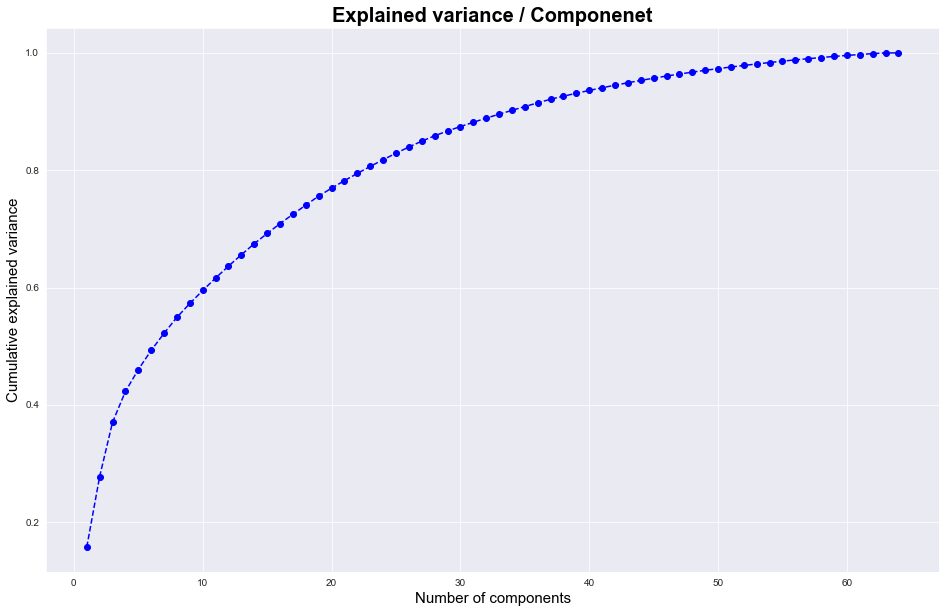

In [240]:
# Investigate the variance accounted for by each principal component.

plt.figure(figsize = (16,10))

plt.plot(range(1 , 65 ), pca.explained_variance_ratio_.cumsum(), marker = 'o' , linestyle = '--' , color = 'blue');


plt.xlabel('Number of components', size = 15 , color = 'black' )
plt.ylabel('Cumulative explained variance', size = 15 , color = 'black' )

plt.title('Explained variance / Componenet', size = 20 , color = 'black' , weight = 'bold')

plt.grid(True)

plt.show();

In [241]:
for i in np.arange(10 , len(pca.explained_variance_ratio_) , 2):
    print(f'{i} componenets: evr = {pca.explained_variance_ratio_[:i].sum()}')

10 componenets: evr = 0.5950726669004484
12 componenets: evr = 0.6365570873762371
14 componenets: evr = 0.6747752340858157
16 componenets: evr = 0.7090329414237385
18 componenets: evr = 0.7405267454463585
20 componenets: evr = 0.7693978429952939
22 componenets: evr = 0.7945785025990935
24 componenets: evr = 0.8179387693710454
26 componenets: evr = 0.8396003390675536
28 componenets: evr = 0.8587010183212647
30 componenets: evr = 0.8744098362966328
32 componenets: evr = 0.8888014815853724
34 componenets: evr = 0.9020509447932136
36 componenets: evr = 0.9148782119618106
38 componenets: evr = 0.9262342712416558
40 componenets: evr = 0.9360138483006895
42 componenets: evr = 0.9449301803669011
44 componenets: evr = 0.9531324486765144
46 componenets: evr = 0.9605750564907853
48 componenets: evr = 0.9671979671739943
50 componenets: evr = 0.9732343359642016
52 componenets: evr = 0.9785667619488201
54 componenets: evr = 0.9835695896807429
56 componenets: evr = 0.988122720245259
58 componenets: e

#### $\color{red}{\text{I am going to select  44 n_components}}$


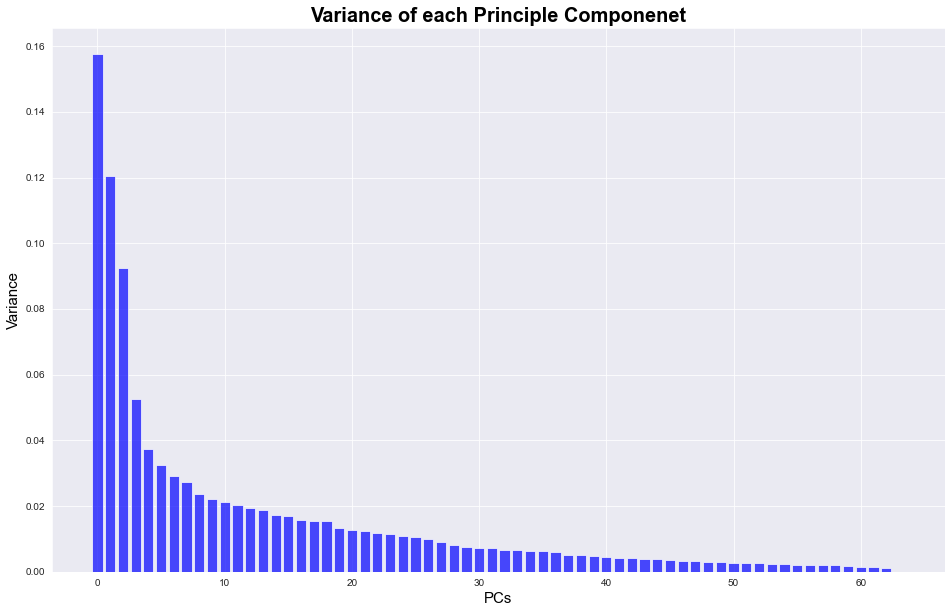

In [242]:

plt.figure(figsize = (16,10))

plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, color = 'blue' , edgecolor = 'white' 
        , alpha = 0.7);


plt.xlabel('PCs', size = 15 , color = 'black' )
plt.ylabel('Variance', size = 15 , color = 'black' )

plt.title('Variance of each Principle Componenet', size = 20 , color = 'black' , weight = 'bold')

plt.grid(True)

plt.show();

In [243]:
# Re-apply PCA to the data while selecting for number of components to retain.

#pca_wnc : with number_components
pca_wnc , azdias_pca_wnc = do_pca(azdias_s , 44)





In [244]:
print(pca_wnc.explained_variance_ratio_)
print(len(pca_wnc.explained_variance_ratio_) )

[0.15758179 0.12032707 0.09249185 0.05252278 0.03736851 0.03259213
 0.02920317 0.02727246 0.02354844 0.02216446 0.0211537  0.02033072
 0.01945882 0.01875932 0.01740591 0.0168518  0.01588686 0.01560695
 0.01539803 0.01347306 0.01286507 0.01231559 0.01187348 0.01148678
 0.01101747 0.01064409 0.00993935 0.00916131 0.00823398 0.00747462
 0.00726339 0.00712795 0.00670992 0.00653926 0.0064262  0.00640076
 0.00614669 0.00520837 0.00499632 0.00477997 0.00458209 0.00432742
 0.00417623 0.00402155]
44


In [245]:
azdias_pca_wnc.shape

(891221, 44)

In [246]:


'''
First: i made a dataframe  x: pca values , y: corresponding features to values

Second: created better dataframe that helps easily track 'explained_variance_ratio' to it's correspond feature


'''
# azdias_evr : explained variance ratio
azdias_evr_wnc = pd.DataFrame(data = np.round(pca.explained_variance_ratio_ , 5) , columns = ['explained_variance_ratio'] ,
                          index = azdias_s.columns)


with pd.option_context('display.max_rows' , None):
    print(azdias_evr)

                       explained_variance_ratio
ALTERSKATEGORIE_GROB                    0.15758
FINANZ_MINIMALIST                       0.12033
FINANZ_SPARER                           0.09249
FINANZ_VORSORGER                        0.05252
FINANZ_ANLEGER                          0.03737
FINANZ_UNAUFFAELLIGER                   0.03259
FINANZ_HAUSBAUER                        0.02920
HEALTH_TYP                              0.02727
RETOURTYP_BK_S                          0.02355
SEMIO_SOZ                               0.02216
SEMIO_FAM                               0.02115
SEMIO_REL                               0.02033
SEMIO_MAT                               0.01946
SEMIO_VERT                              0.01876
SEMIO_LUST                              0.01741
SEMIO_ERL                               0.01685
SEMIO_KULT                              0.01589
SEMIO_RAT                               0.01561
SEMIO_KRIT                              0.01540
SEMIO_DOM                               

### Discussion 2.2: Perform Dimensionality Reduction

I've done several things to capture the suitable number of componenets for principal componenets analysis. 


- I fit data into pca to get Transformed values, after that i applyed those Transformed values into their correspond rows and features.


- To get the best number of components, i made a plot that to check out the ration of variance explained by each principal component as well as the cumulative variance explained


- I felt that was not enough, so i did simple code that iterate over each principal component explained variance ratio and add them on a variable to locate the perfect point of number of componenets 



-  $\color{red} {\text {0.9531324486765096 $\equiv$ 95% is perfect which leads to 44 number of  componenets}}$




### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [247]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

# abstracting


def weight_subset(subset_n):
    
    pca_weights = pd.DataFrame(data = np.round(pca_wnc.components_ , 4) , 
                           columns = azdias_s.columns[: len(azdias_s.columns)])
    
    return pca_weights.iloc[subset_n].sort_values(ascending = False)


weight1 = weight_subset(0) 
with pd.option_context('display.max_rows' , None):
    print(weight1[:5],'\n----------------')
    print(weight1[59:])

PLZ8_ANTG3            0.2397
PLZ8_ANTG4            0.2329
ORTSGR_KLS9           0.2101
EWDICHTE              0.2099
HH_EINKOMMEN_SCORE    0.1782
Name: 0, dtype: float64 
----------------
FINANZ_MINIMALIST   -0.2191
KBA05_GBZ           -0.2289
KBA05_ANTG1         -0.2341
PLZ8_ANTG1          -0.2390
MOBI_REGIO          -0.2539
Name: 0, dtype: float64


In [248]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weight2 = weight_subset(1)

with pd.option_context('display.max_rows' , None):
    print(weight2[:5],'\n----------------')
    print(weight2[59:])


ALTERSKATEGORIE_GROB    0.2815
FINANZ_VORSORGER        0.2522
SEMIO_ERL               0.2471
SEMIO_LUST              0.1920
RETOURTYP_BK_S          0.1724
Name: 1, dtype: float64 
----------------
FINANZ_UNAUFFAELLIGER   -0.2411
SEMIO_TRADV             -0.2445
SEMIO_PFLICHT           -0.2557
FINANZ_SPARER           -0.2606
SEMIO_REL               -0.2721
Name: 1, dtype: float64


In [249]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weight3 = weight_subset(2)

with pd.option_context('display.max_rows' , None):
    print(weight3[:5],'\n----------------')
    print(weight3[59:])

SEMIO_VERT           0.3544
SEMIO_SOZ            0.2886
SEMIO_KULT           0.2678
SEMIO_FAM            0.2193
FINANZ_MINIMALIST    0.1350
Name: 2, dtype: float64 
----------------
FINANZ_ANLEGER   -0.1938
SEMIO_KRIT       -0.3050
SEMIO_DOM        -0.3269
SEMIO_KAEM       -0.3523
ANREDE_KZ        -0.3533
Name: 2, dtype: float64


### Discussion 2.3: Interpret Principal Components




- First Principal Componenet:

    
    - Positive Correlation:
    
            PLZ8_ANTG3            0.2397
            PLZ8_ANTG4            0.2329
            ORTSGR_KLS9           0.2101
            EWDICHTE              0.2099
            HH_EINKOMMEN_SCORE    0.1782
        
    - Negative Correlation: 
    
            FINANZ_MINIMALIST   -0.2191
            KBA05_GBZ           -0.2289
            KBA05_ANTG1         -0.2341
            PLZ8_ANTG1          -0.2390
            MOBI_REGIO          -0.2539
            
            
`PLZ8_ANTG3` & `PLZ8_ANTG4` have strong positive correlation unlike `PLZ8_ANTG1`: this leads that 6-10 family houses and 10+ family houses tend to live in PLZ8 region more together unlike 1-2 family houses.



`PLZ8_ANTG3` & `PLZ8_ANTG4` have strong negative correlation with MOBI_REGIO:  Households whose members count is higher than 6;  seems that their movement pattern-`MOBI_REGIO`- is much lower than householdes whose family members count is between 1-2
-`PLZ8_ANTG1`- . 



`PLZ8_ANTG3` & `PLZ8_ANTG4` have strong positive correlation with `HH_EINKOMMEN_SCORE`-estimated household income-.



--------------------------
--------------------------
--------------------------



- Second Principal Componenet:


    - Positive Correlation:

            ALTERSKATEGORIE_GROB    0.2815
            FINANZ_VORSORGER        0.2522
            SEMIO_ERL               0.2471
            SEMIO_LUST              0.1920
            RETOURTYP_BK_S          0.1724
    
    - Negative Correlation: 

            FINANZ_UNAUFFAELLIGER   -0.2411
            SEMIO_TRADV             -0.2445
            SEMIO_PFLICHT           -0.2557
            FINANZ_SPARER           -0.2606
            SEMIO_REL               -0.2721

It seems that `ALTERSKATEGORIE_GROB`, `FINANZ_VORSORGER`, and `SEMIO_ERL` have strong positive correlation which explains person's typology based on specific factors such as name relative to age, financial culture and personality such as affinity.


unlike  `SEMIO_REL`, `FINANZ_SPARER`, and `SEMIO_PFLICHT` have strong negative correlation which is weak.





--------------------------
--------------------------
--------------------------



- Third Principal Component


     - Positive Correlation:

            SEMIO_VERT           0.3544
            SEMIO_SOZ            0.2886
            SEMIO_KULT           0.2678
            SEMIO_FAM            0.2193
            FINANZ_MINIMALIST    0.1350

    - Negative Correlation: 
    
            FINANZ_ANLEGER   -0.1938
            SEMIO_KRIT       -0.3050
            SEMIO_DOM        -0.3269
            SEMIO_KAEM       -0.3523
            ANREDE_KZ        -0.3533


It seems that `SEMIO_VERT`, `SEMIO_SOZ`, `SEMIO_KULT`, and `SEMIO_FAM` are strong positive features that describe personality typology in the following trait order: VERT: dreamful, SOZ: social-minded, KULT: cultural-minded, and FAM: family-minded which is intersting that top four features all describe personality of individual. It seems that it explains Personality typology and their relation of low financial interest trait -FINANZ_MINIMALIST- .

          



## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [250]:
# Over a number of different cluster counts...

iterations = np.arange(1,21 ,1)

scores = []


def get_Kmeans_Score(df , n):
    
    kmeans = KMeans(n_clusters = n)
    
    model = kmeans.fit(df)
    
    score = np.abs(model.score(df))
    
    return score

# azdias_pca_wnc

    # run k-means clustering on the data and...

for index in iterations:
    scores.append(get_Kmeans_Score(azdias_pca_wnc , index))
    
    

In [251]:
print(scores)

[54363950.77884445, 47977399.40077493, 44311442.02914392, 41864274.4203333, 40219068.535240725, 38910451.13329198, 37695454.77279242, 36652050.60471274, 35795656.7912921, 35021657.49719739, 34240559.146461874, 33576655.5983215, 33084766.162739575, 32601216.700622, 32216921.629934642, 32020840.246492676, 31421250.30029881, 31114259.838098053, 30486911.53107205, 30227686.12246911]


In [252]:

# previos scores 
# saved it temprary to reduce waiting time for result for testing and debugging
scores2 = [57038143.999996513, 50651180.025542088, 46983366.11282181, 44531093.36086347, 42883748.632869326, 
           41566133.022785284, 40354754.564205527, 39308843.276135534, 38456680.923484251, 37628550.329629771, 
           36924074.262415178, 36218117.248131223, 35731418.565921947, 35502720.334630527, 34687196.087760918,
           34320499.447341971, 34194935.700943016, 33536346.753818829, 33248542.916936491, 32910533.085027702]

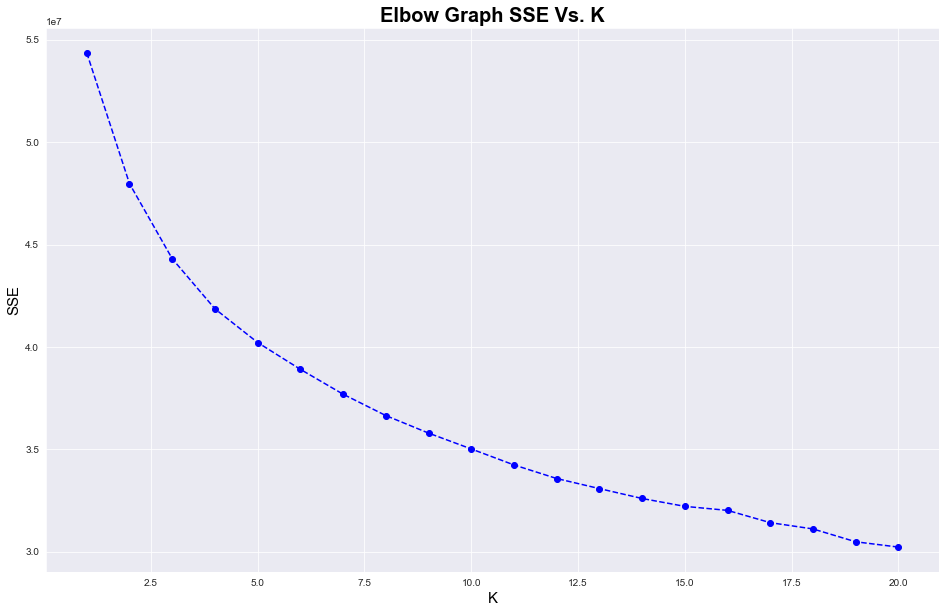

In [253]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.figure(figsize = (16,10))


plt.plot(iterations , scores , marker = 'o' , linestyle = '--' , color = 'blue'  )



plt.xlabel('K', size = 15 , color = 'black' )
plt.ylabel('SSE', size = 15 , color = 'black' )

plt.title('Elbow Graph SSE Vs. K', size = 20 , color = 'black' , weight = 'bold')

plt.grid(True)

plt.show();

In [254]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

KM = KMeans(n_clusters = 17)

# model_ch : model chosen
model_ch = KM.fit(azdias_pca_wnc)


# prediction

# azdias_p : p---> prediction
azdias_p = model_ch.predict(azdias_pca_wnc)



In [255]:
azdias_p

array([ 8, 12,  6, ...,  7,  1, 10])

### Discussion 3.1: Apply Clustering to General Population



$\color{red}{\text{After considerating Elbow scree plot; I concluded that 17 is the chosen number of clusters}}$



### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [256]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv' , sep = ';')

# for testing purposes
#dummy1 = pd.read_csv('Udacity_AZDIAS_Subset.csv' , sep = ';')

customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [257]:
# testing
#dummy_c = clean_data(dummy1)

#c_c = clean_data(customers)

In [258]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.



# applying dataframe into cleaning function
# cc : customoers dataframe after cleaning
cc = clean_data(customers)

# for unknown reason, this features reamined even after dropping. So i dropped it
cc.drop('KBA05_BAUMAX' , inplace = True , axis = 1)


# Imputing & scaling ---> using StandardScaling as recommended
cc_imp = imp.transform(cc)

# scaled
cc_ss = scaler.transform(cc_imp)




# applying pca function using chosen number

ccis_pca = pca_wnc.transform(cc_ss)


25


In [260]:
ccis_pca

array([[-5.77877988,  1.33279119,  4.16898736, ...,  0.06535897,
        -0.20767098, -0.38496475],
       [-1.56750122,  1.41273265,  3.19063018, ..., -0.8434505 ,
         0.20765541, -0.36693448],
       [-1.06706782,  4.8062893 , -1.10245019, ...,  0.25072278,
         0.28008699, -0.82284984],
       ...,
       [-4.3814664 ,  3.10029143,  2.41673673, ...,  1.05565979,
        -0.10840027, -0.06149804],
       [-0.78800022,  2.91354551, -1.85344525, ..., -0.20740908,
        -0.2462691 ,  0.42304913],
       [-4.08793439, -2.93873541,  2.3388731 , ..., -1.39220227,
         0.41249283,  0.67375393]])

In [261]:
print(cc.shape)
print(cleaned_azdias.shape)
print(azdias_pca_wnc.shape)
print(ccis_pca.shape)

(191652, 64)
(891221, 64)
(891221, 44)
(191652, 44)


In [262]:
ccis_pca

array([[-5.77877988,  1.33279119,  4.16898736, ...,  0.06535897,
        -0.20767098, -0.38496475],
       [-1.56750122,  1.41273265,  3.19063018, ..., -0.8434505 ,
         0.20765541, -0.36693448],
       [-1.06706782,  4.8062893 , -1.10245019, ...,  0.25072278,
         0.28008699, -0.82284984],
       ...,
       [-4.3814664 ,  3.10029143,  2.41673673, ...,  1.05565979,
        -0.10840027, -0.06149804],
       [-0.78800022,  2.91354551, -1.85344525, ..., -0.20740908,
        -0.2462691 ,  0.42304913],
       [-4.08793439, -2.93873541,  2.3388731 , ..., -1.39220227,
         0.41249283,  0.67375393]])

In [263]:
# predict
ccis_pred = model_ch.predict(ccis_pca)

In [264]:
# number of clusters after prediction

set(ccis_pred)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [265]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

#creates a sample of each cluster in customer and general(azdias) datasets

azdias_p_list = np.array(azdias_p)
ccis_pred_list = np.array(ccis_pred)

# general_s : general sample that is going to contain sample from each cluster
general_s , customer_s = [] , []



for i in range(17):
    general_s.append((np.sum(azdias_p_list == i) / len(azdias_p_list) *100))
    customer_s.append((np.sum(ccis_pred_list == i) / len(ccis_pred_list) * 100))
    
    


In [266]:
print(general_s , '\n\n' , customer_s)

[7.077817959855075, 5.728882061800608, 8.368294732731837, 6.67241907450565, 5.471482382035433, 6.540240860572181, 8.623450300206121, 9.293991052724296, 9.113564424536676, 0.35715047109527265, 6.735478629879682, 3.581939833105369, 0.7687206652446474, 3.739588721540448, 7.928785340560871, 6.714496179959853, 3.2836973096459805] 

 [11.039279527476884, 0.4873416400559347, 0.6903136935695948, 22.911840210381314, 0.8671967941894685, 4.603656627637593, 5.269446705487028, 1.192786926303926, 24.402562978732288, 1.4328052929267632, 7.574144804124142, 5.476592991463694, 0.7294471229102748, 2.0912904639659384, 5.191179846805668, 4.077181558240978, 1.962932815728508]


In [267]:
def plot_comparison(first , second):
    plt.figure( figsize= (18 , 8) )
   
   
    #yl : y-axis ticks
    yt = range(2 , int(max(first)+4) , 2)
    
    
#     # yl : y-axis labels
    yl = []
    
    for i in yt:
        yl.append(f'{i}%')
        
   # first plot
    plt.subplot(1,2,1)
    
    sns.barplot(x = list(range(17)) , y = first)
    
    plt.yticks(yt , yl)
    
    plt.tick_params(axis = 'x', which = 'major', labelsize = 14)
    plt.tick_params(axis = 'y', which = 'major', labelsize = 14)
    plt.xlabel('General Cluster', size = 15 , color = 'black' , weight = 'bold')
    
    plt.ylabel('Count', size = 15 , color = 'black' , weight = 'bold')
    
    
    plt.title('General Sample Cluster', size = 20 , color = 'black' , weight = 'bold')
    
    #second plot
    
    plt.subplot(1,2,2)
    
    sns.barplot( x = list(range(17)) , y = second)
    
    
    # yt: y-axis ticks
    yt = range(2 , int(max(second)+4) , 2)
    
    
    # yl : y-axis labels
    yl = []
    
    for i in yt:
        yl.append(f'{i}%')
                   
    plt.yticks(yt , yl)
    
    plt.tick_params(axis = 'x', which = 'major', labelsize = 14 )
    plt.tick_params(axis = 'y', which = 'major', labelsize = 14 )
    plt.xlabel('Customer Cluster', size = 15 , color = 'black' , weight = 'bold')
    
    plt.ylabel('Count', size = 15 , color = 'black' , weight = 'bold')
    
    plt.title('Customer Sample Cluster', size = 20 , color = 'black' , weight = 'bold')
    
    
              
    plt.show();
    
    
    
    
    
    

In [268]:
def third_plot(df):

# Third plot

    plt.figure()
    

    ax = df_all.plot(kind = 'bar' , figsize = (18,15) , color = ['y' , 'b'] , align = 'edge' , width = 0.4 , alpha = 0.7)

    plt.xticks(range(df_all.shape[0]) , rotation = 360)
    plt.tick_params(axis = 'x', which = 'major', labelsize = 14 )
    plt.tick_params(axis = 'y', which = 'major', labelsize = 14 )


    yt = range(2 , 28 , 2)


    # yl : y-axis labels
    yl = []

    for i in yt:
        yl.append(f'{i}%')

    plt.yticks(yt , yl)

    plt.xlabel('Cluster Number', size = 15 , color = 'black' , weight = 'bold')
    plt.ylabel('%', size = 15 , color = 'black' , weight = 'bold')
    plt.title('Grouped comparison between "General vs. Customer" ', size = 20 , color = 'black' , weight = 'bold')
    plt.legend(fontsize = 15)

    plt.show();

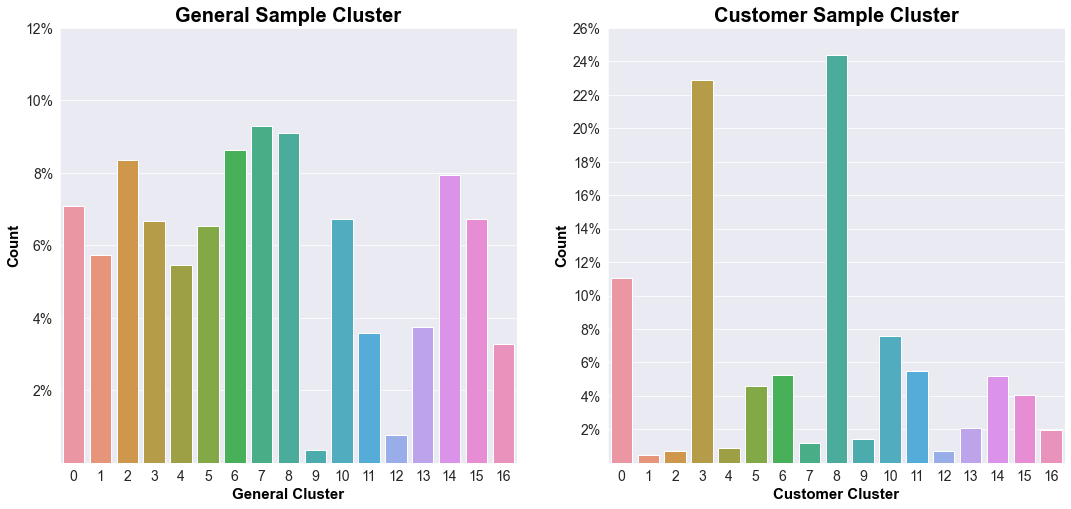

In [269]:
plot_comparison(general_s , customer_s)

In [270]:
df_all = pd.DataFrame({'general' : general_s , 'customer': customer_s})
df_all

,general,customer
0,7.077818,11.039280
1,5.728882,0.487342
2,8.368295,0.690314
3,6.672419,22.911840
4,5.471482,0.867197
5,6.540241,4.603657
6,8.623450,5.269447
7,9.293991,1.192787
8,9.113564,24.402563
9,0.357150,1.432805


In [271]:
df_all.shape

(17, 2)

<Figure size 432x288 with 0 Axes>

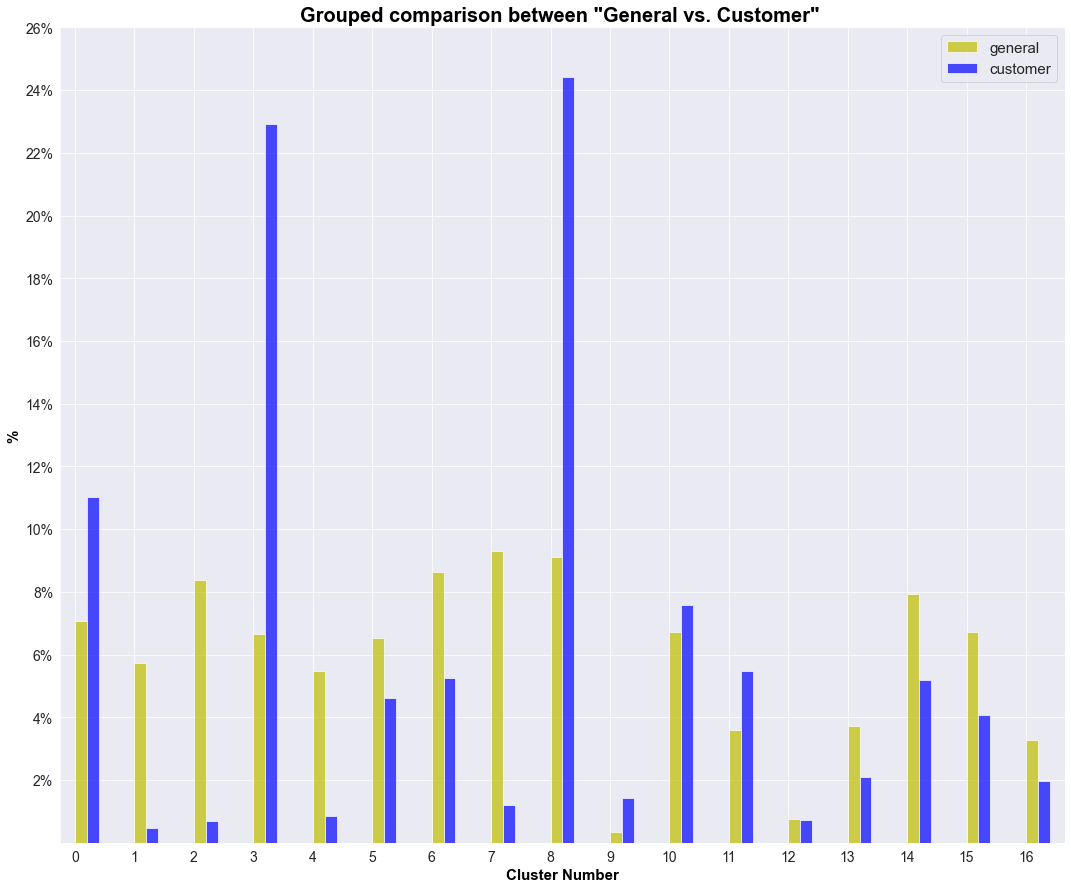

In [272]:
third_plot(df_all);

In [273]:
cleaned_azdias['label'] = azdias_p.reshape(-1,1)

In [277]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Printing 
for c in list(cc):
    print(cleaned_azdias[cleaned_azdias.label == 8][c].value_counts())

3.0    47687
2.0    17996
1.0    15493
4.0        3
Name: ALTERSKATEGORIE_GROB, dtype: int64
3    74602
1     4305
2     1758
4      391
5      166
Name: FINANZ_MINIMALIST, dtype: int64
4    75736
5     4803
3      411
2      171
1      101
Name: FINANZ_SPARER, dtype: int64
3    78768
2     1728
1      355
4      267
5      104
Name: FINANZ_VORSORGER, dtype: int64
5    79762
4      877
3      274
2      201
1      108
Name: FINANZ_ANLEGER, dtype: int64
5    78026
4     2340
3      685
2      134
1       37
Name: FINANZ_UNAUFFAELLIGER, dtype: int64
3    75055
5     2934
4     1606
2     1123
1      504
Name: FINANZ_HAUSBAUER, dtype: int64
3.0    212
2.0     16
1.0      7
Name: HEALTH_TYP, dtype: int64
3.0    52462
5.0    15446
4.0     4878
1.0     4706
2.0     3684
Name: RETOURTYP_BK_S, dtype: int64
2    77126
4     1553
5     1317
1      935
3      289
6        2
Name: SEMIO_SOZ, dtype: int64
6    76870
4     2180
5     1688
2      449
1       21
3       14
Name: SEMIO_FAM, dtype: int6

In [295]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



for c in list(cc):
    print(cleaned_azdias[cleaned_azdias.label == 7][c].value_counts())


2.0    41029
1.0    35514
3.0     6016
4.0        8
Name: ALTERSKATEGORIE_GROB, dtype: int64
1    30082
2    17418
4    17066
3    15483
5     2781
Name: FINANZ_MINIMALIST, dtype: int64
4    32192
5    26306
3    15113
2     7466
1     1753
Name: FINANZ_SPARER, dtype: int64
2    25890
1    23977
3    22481
4     8785
5     1697
Name: FINANZ_VORSORGER, dtype: int64
5    44509
4    24926
3     9159
2     3407
1      829
Name: FINANZ_ANLEGER, dtype: int64
5    34146
4    23807
3    16051
2     5750
1     3076
Name: FINANZ_UNAUFFAELLIGER, dtype: int64
2    20299
1    18573
4    17976
3    15096
5    10886
Name: FINANZ_HAUSBAUER, dtype: int64
3.0    36521
2.0    27927
1.0    14219
Name: HEALTH_TYP, dtype: int64
1.0    26778
4.0    20023
2.0    18777
3.0    11576
5.0     5277
Name: RETOURTYP_BK_S, dtype: int64
2    43079
5    13404
1    10651
4     8296
3     7397
6        3
Name: SEMIO_SOZ, dtype: int64
5    28656
4    27034
2    24888
3     1195
1      576
6      481
Name: SEMIO_FAM, dtype

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

- $\color{red}{\text{kinds of people that are part of cluster ==#8== that is overrepresented in the customer data compared to the general population:}}$

        
        
    - Most of customers are in range 46-60 years old customers.
    
    
    - There are large diversity in Finance typologies of customers.
       
       - Customers have average financial interest
       - Low money savers
       - Customers seem to be average financially prepared
       - Very low investors
       - Very low inconspicuous
       - Average home owners.
    
    
    - Most of custmers are incentive-receptive Normal-Returner.
    
    - Customers seem to have diverse personality traits/typologies. 
      I'm going to mention the most intersted ones:
      
        - We can find that 95% of customers are at very high social minded level
        - 95% of customers are at very low family-minded level
        - 99% of customers are non-religios 
        - 97% of customers seems to low level materialistic 
        - 95% of customers are are very highly dreamlful
        - 94% of customers are between rational and irrational (average)
        - Customers seems to be not critical minded, very low affinity to be dominant minded, very low combative attitude, 
          low dutiful and seems to be ok(above average) traditional-minded
        
    - Customers seem to to have very high income.
    
    - Most customers seem to have middle Online Affinity.
    
    - 99% of customers are not a member of green avantgarde.
------------------------------
------------------------------
------------------------------

- $\color{red}{\text{Kinds of people are part of a cluster ==#7== that is underrepresented in the
customer data compared to the general population: }}$


    - It seems customers are between < 30 years old and between 30-45 years old
    - There are large diversity in Finance typologies of customers.
       
       - Customers have high finiancial typology diversity in low financial interest
       - Customers are not money savers
       - Customers have average and above finiancial typology diversity of 'be prepared'
       - Most customers are non investors
       - Customers seem to have average to very low typology in low inconspicuous
       - Customers are mostly home owners.

    - Customers seem to be distributed to all health typology:

        - critical reserved 18%
        - sanitary affine : 36%
        - jaunty hedonists: 46%
        
     - Customers seem to be distributed to all 'return type' typology:
       
        - The lowest type amoung all of the five types is a determined Minimal-Returner customer
        
        
     - Customers seem to have diverse personality traits/typologies. 
          I'm going to mention the most intersted ones:
      
        - We can find that most of customers are at high social minded level
        - 30% of customers are considered to have high family-minded level and 67% are considered to have average to low                     family minded level
        - Most Customers are non-religios or have weak faith  
        - Most of customers seem to be non-materialistic
        - More than 60% of customers seem to be dreamful
        - Most costumers are considered sensual-minded
        - Most costumers are not even-oriented
        - Most costumers are irrational
        - Customers seems to be not critical minded, very low affinity to be dominant minded, very low combative attitude, 
          low dutiful and seems to be very low traditional-minded
    
    
    - Majority of Customers seem to be classified in middle class households.
    
    - Most costumers are likely/most likely to have children in their household.
    
    - Most costumers have length of residence more than 10 years.
        
    - Most costomer's buildings are located in a (1 x 1km to 2 x 2km) grid cell that includes at least one
      RA1-consumption cell
      
     
     - Most urban centers are reached by costumers using vechile, underground or train. Distance: 50-100+km

     - Most city centers are reached by costumers using vechile or tram or even taxi. Distance: 10-20-30km


     - Most costumers seem to have low/very low movement pattern
     
     - Most costumers are living in (lower middle class , traditional workers, and conservatives) Neighborhoods types
     
     - Most customers are not a member of green avantgarde.
     
     - 85% of costumers Buildings location via former are in West Germany (FRG)
     
     - 79% of movements are 'west & mainstream'     
     

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.